<a href="https://colab.research.google.com/github/MakhovaAnastasia/Paper_Fuzzy_LSTM/blob/main/Fuzzy_data_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Fuzzy LSTM –¥–ª—è –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è —Ü–µ–Ω.***

–ò–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º –Ω—É–∂–Ω—ã–µ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏

In [ ]:
import pandas as pd
from keras.layers import Dense, Activation, Dropout, Input
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics  import mean_squared_error
import math
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date,timedelta
import sklearn.metrics
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,mean_absolute_percentage_error
from keras.utils import get_custom_objects
import time
from prettytable import PrettyTable

–°–æ–±–∏—Ä–∞–µ–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ —Ä–∞–∑–Ω—ã—Ö —Ç–µ–Ω–æ—Ä–∞—Ö

In [ ]:
def get_historical_close_data(name,step):
  if step=='1d':
    start = '2018-01-01'
    end = '2024-02-15'
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1d')
    data.reset_index(inplace=True)
    data = data.loc[:,('Date','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1h':
    start = '2023-01-01'
    end = '2024-02-15'
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1h')
    data.reset_index(inplace=True)
    data = data.loc[:,('Datetime','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1m':
    start = date.today()-timedelta(days=7)
    end = date.today()
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1m')
    data.reset_index(inplace=True)
    return data

–ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö –∏ –¥–µ–Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è

In [ ]:
def normalization(data):
    scaler = MinMaxScaler(feature_range = (0,1))
    data_norm = scaler.fit_transform(data)

    return data_norm

In [ ]:
def de_normalization(data, new_data):
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit_transform(data)
    unormalized = scaler.inverse_transform(new_data)

    return unormalized

**–ì–∞—É—Å—Å–∏–∞–Ω—ã.**–î–ª—è –∫–∞–∂–¥–æ–≥–æ –º–æ–º–µ–Ω—Ç–∞ –≤—Ä–µ–º–µ–Ω–∏ $t_i$ —Å–æ–ø–æ—Å—Ç–∞–≤–∏–º –∏–∑–≤–µ—Å—Ç–Ω–æ–º—É –∑–Ω–∞—á–µ–Ω–∏—é —Ä—è–¥–∞ $x_i$ –Ω–µ—á–µ—Ç–∫–æ–µ –º–Ω–æ–∂–µ—Å—Ç–≤–æ, –∑–∞–¥–∞—é—â–µ–µ—Å—è —Ñ—É–Ω–∫—Ü–∏–µ–π –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏ –≥–∞—É—Å—Å–æ–≤—Å–∫–æ–≥–æ —Ç–∏–ø–∞ $$ m(x) = \exp(- (\frac{x - c}{\sigma})^2)$$ —Å –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ $c = x_i$ –∏ $\sigma = \hat\sigma(t_i, l)$-- –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å —Ä—è–¥–∞ –∑–∞ –ø–µ—Ä–∏–æ–¥ –¥–ª–∏–Ω—ã $l$: $[t_{i-l}, t_i]$. –¢–æ –µ—Å—Ç—å –≤–µ—Ä—à–∏–Ω–∞ –≥–∞—É—Å—Å–æ–≤—Å–∫–æ–≥–æ –∫—É–ø–æ–ª–∞ –±—É–¥–µ—Ç –∫–∞–∫ —Ä–∞–∑ –≤ $x_i$ –∏ –µ–≥–æ —à–∏—Ä–∏–Ω–∞'' –±—É–¥–µ—Ç —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–æ–≤–∞—Ç—å —à–∏—Ä–∏–Ω–µ'' –æ–±–æ–∑—Ä–µ–≤–∞–µ–º–æ–≥–æ —Ä—è–¥–∞.


------



–ø—Ä–æ–≥–Ω–æ–∑: $c$

In [ ]:
# 2. –§–∞–∑–∑–∏—Ñ–∏–∫–∞—Ü–∏—è (–≥–∞—É—Å—Å–æ–≤–∞—è)
def compute_volatility(data, window):
    return pd.Series(data.flatten()).rolling(window).std().bfill().values

def fuzzify(data, window=10):
    sigma = compute_volatility(data, window)
    return np.exp(-((data.flatten() - data.flatten())**2) / (sigma**2 + 1e-8)).reshape(-1, 1)

In [ ]:
def create_dataset_multifeature_1(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback), :]     # —Ç–µ–ø–µ—Ä—å –±–µ—Ä–µ–º –≤—Å–µ —Ñ–∏—á–∏
        dataX.append(a)
        dataY.append(dataset[i + lookback, 0])  # —Ü–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è ‚Äî –≤—Å—ë —Ç–∞–∫ –∂–µ –ø–µ—Ä–≤–∞—è (–Ω–æ—Ä–º. —Ü–µ–Ω–∞)
    return np.array(dataX), np.array(dataY)

–†–∞–∑–±–∏–≤–∞–µ–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é –∏ —Ç–µ—Å—Ç–æ–≤—É—é –≤—ã–±–æ—Ä–∫—É –∏ –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∏—Ö –≤ –Ω—É–∂–Ω—ã–π –¥–ª—è LSTM —Ñ–æ—Ä–º–∞—Ç

In [ ]:
def split_train_test(data):

    # split into train and test sets
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size,], data[train_size:len(data),]
    return train, test

def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
      a = dataset[i:(i+lookback), 0]
      dataX.append(a)
      dataY.append(dataset[i + lookback, 0])
    return np.array(dataX), np.array(dataY)

–¢–∞–∫ –∫–∞–∫ –≤ LSTM –±–∞–∑–æ–≤–∞—è —Ñ—É–Ω–∫—Ü–∏—è –∞–∫—Ç–∏–≤–∞—Ü–∏–∏ -- tanh, –ø–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º –ø—Ä–æ—à–ª—ã—Ö –ª–µ—Ç –≤—ã–±–∏—Ä–∞–µ–º —Å–ª–µ–¥—É—é—â–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

–ü–æ–¥–≥–æ—Ç–∞–≤–ª–∏–≤–∞–µ–º –¥–∞–Ω–Ω—ã–µ: —Å–∫–∞—á–∏–≤–∞–µ–º, –Ω–æ—Ä–º–∞–ª–∏–∑—É–µ–º, —Ñ–æ—Ä–º–∏—Ä—É–µ–º –≤—ã–±–æ—Ä–∫–∏

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))

In [ ]:
# === –§–∞–∑–∑–∏-–ø—Ä–∏–∑–Ω–∞–∫ ===
fuzzy_feature = fuzzify(dataset_norm, window)

# –î–æ–±–∞–≤–∏–º —Ñ–∞–∑–∑–∏-–ø—Ä–∏–∑–Ω–∞–∫ –≤ –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç
dataset_fuzzy = np.hstack((dataset_norm, fuzzy_feature))  # shape = (n_samples, 2)

train_dataset_fuzzy, test_dataset_fuzzy = split_train_test(dataset_fuzzy)

train_X, train_y = create_dataset_multifeature_1(train_dataset_fuzzy, lookback)
test_X, test_y = create_dataset_multifeature_1(test_dataset_fuzzy, lookback)



train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 2)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 2)


–ó–∞–ø—É—Å–∫–∞–µ–º –æ–±—É—á–µ–Ω–∏–µ LSTM —Å —Ñ—É–Ω–∫—Ü–∏–µ–π –ø–æ—Ç–µ—Ä—å MSE –∏ –∞–ª–≥–æ—Ä–∏—Ç–º–æ–º –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ ADAM

In [ ]:
model=Sequential()
model.add(Input(shape=(lookback,2)))
model.add(LSTM(unit))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
start_time = time.time()
result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
end_time = time.time()
train_timing=(end_time-start_time)
print(f"time = {train_timing}")

time = 245.79169940948486


–î–µ–ª–∞–µ–º –ø—Ä–æ–≥–Ω–æ–∑ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –∏ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ

In [ ]:
train_predict=model.predict(train_X)
start_time = time.time()
test_predict=model.predict(test_X)
end_time = time.time()
test_timing=(end_time-start_time)
print(f"time = {test_timing}")

199/199 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step
66/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
time = 0.2873110771179199


–í–æ–∑–≤—Ä–∞—â–∞–µ–º –¥–∞–Ω–Ω—ã–µ –≤ –∏—Å—Ö–æ–¥–Ω—ã–µ –µ–¥–∏–Ω–∏—Ü—ã –∏–∑–º–µ—Ä–µ–Ω–∏—è

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

–ì—Ä–∞—Ñ–∏–∫ —Å –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏ –∏ –ø—Ä–æ–≥–Ω–æ–∑–∞–º–∏:

In [ ]:
trainPredictPlot = np.empty_like(dataset_norm)
trainPredictPlot[:, ] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
testPredictPlot = np.empty_like(dataset_norm)
testPredictPlot[:,] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)

In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

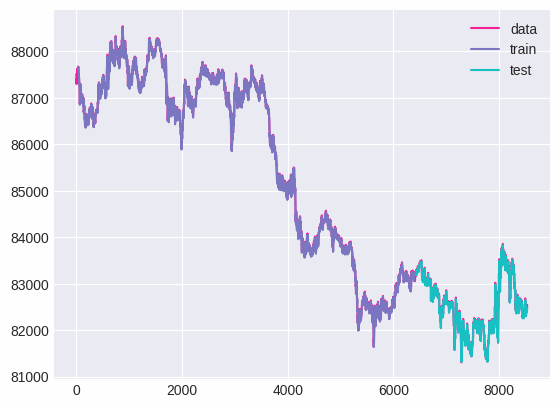

In [ ]:
plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
plt.plot(trainPredictPlot,color = 'C0', label = 'train')
plt.plot(testPredictPlot,color = 'C3', label = 'test')
plt.legend()
plt.show()

–ú–µ—Ç—Ä–∏–∫–∏:

In [ ]:
rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
mae_train=mean_absolute_error(original_ytrain,train_predict)
mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
mae_test=mean_absolute_error(original_ytest,test_predict)
mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)


+---------+------------------------+-----------------------+
| RESULTS |         TRAIN          |          TEST         |
+---------+------------------------+-----------------------+
|   rmse  |   45.127556972035784   |   54.357152575924296  |
|   mae   |   33.22336608685409    |    37.8815599726451   |
|   mape  | 0.00038766448339120604 | 0.0004588537718929537 |
+---------+------------------------+-----------------------+


–ì—Ä–∞—Ñ–∏–∫ —Ñ—É–Ω–∫—Ü–∏–π –ø–æ—Ç–µ—Ä—å:

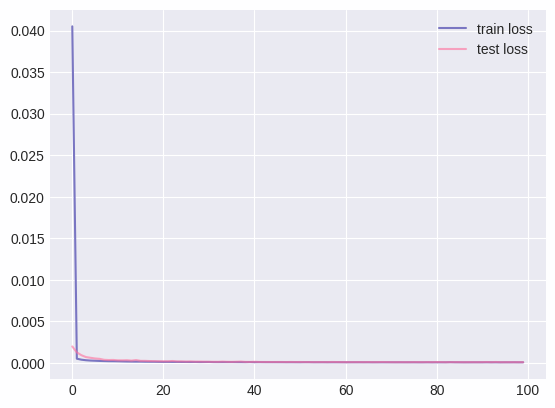

In [ ]:
plt.plot(result.history['loss'],label = 'train loss')
plt.plot(result.history['val_loss'],label = 'test loss')
plt.legend()
plt.show()

---------

–ø—Ä–æ–≥–Ω–æ–∑: $(c, \sigma)$

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

–ü–æ–¥–≥–æ—Ç–∞–≤–ª–∏–≤–∞–µ–º –¥–∞–Ω–Ω—ã–µ: —Å–∫–∞—á–∏–≤–∞–µ–º, –Ω–æ—Ä–º–∞–ª–∏–∑—É–µ–º, —Ñ–æ—Ä–º–∏—Ä—É–µ–º –≤—ã–±–æ—Ä–∫–∏

In [ ]:
# 3. –°–æ–∑–¥–∞–Ω–∏–µ –¥–∞—Ç–∞—Å–µ—Ç–∞ —Å –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏
def create_dataset_multifeature(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i:(i + lookback), :]
        dataX.append(a)
        dataY.append(dataset[i + lookback, :])  # —Ç–µ–ø–µ—Ä—å y ‚Äî –≤–µ–∫—Ç–æ—Ä –∏–∑ 2 –∑–Ω–∞—á–µ–Ω–∏–π
    return np.array(dataX), np.array(dataY)

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))

In [ ]:
# === –§–∞–∑–∑–∏-–ø—Ä–∏–∑–Ω–∞–∫ ===
fuzzy_feature = fuzzify(dataset_norm, window)

# –î–æ–±–∞–≤–∏–º —Ñ–∞–∑–∑–∏-–ø—Ä–∏–∑–Ω–∞–∫ –≤ –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç
dataset_fuzzy = np.hstack((dataset_norm, fuzzy_feature))  # shape = (n_samples, 2)

train_dataset_fuzzy, test_dataset_fuzzy = split_train_test(dataset_fuzzy)

train_X, train_y = create_dataset_multifeature(train_dataset_fuzzy, lookback)
test_X, test_y = create_dataset_multifeature(test_dataset_fuzzy, lookback)


train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 2)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 2)


In [ ]:
# === –ú–æ–¥–µ–ª—å ===
model = Sequential()
model.add(Input(shape=(lookback, 2)))  # –í–æ—Ç —Ç–∞–∫ –ø—Ä–∞–≤–∏–ª—å–Ω–æ
model.add(LSTM(unit))
model.add(Dense(2))  # –í—ã—Ö–æ–¥: [–ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —Ü–µ–Ω—ã, –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏]
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# === –û–±—É—á–µ–Ω–∏–µ ===
start_time = time.time()
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=False)
train_time = time.time() - start_time
print(f"time = {train_time}")

time = 249.47161436080933


In [ ]:
# === –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è ===
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

199/199 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step
66/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step


+---------+-----------------------+-----------------------+
| RESULTS |         TRAIN         |          TEST         |
+---------+-----------------------+-----------------------+
|   rmse  |   42.46293475116366   |   52.60346461697107   |
|   mae   |   30.12175082456416   |   35.594210870599426  |
|   mape  | 0.0003514568552370249 | 0.0004312438686134726 |
+---------+-----------------------+-----------------------+


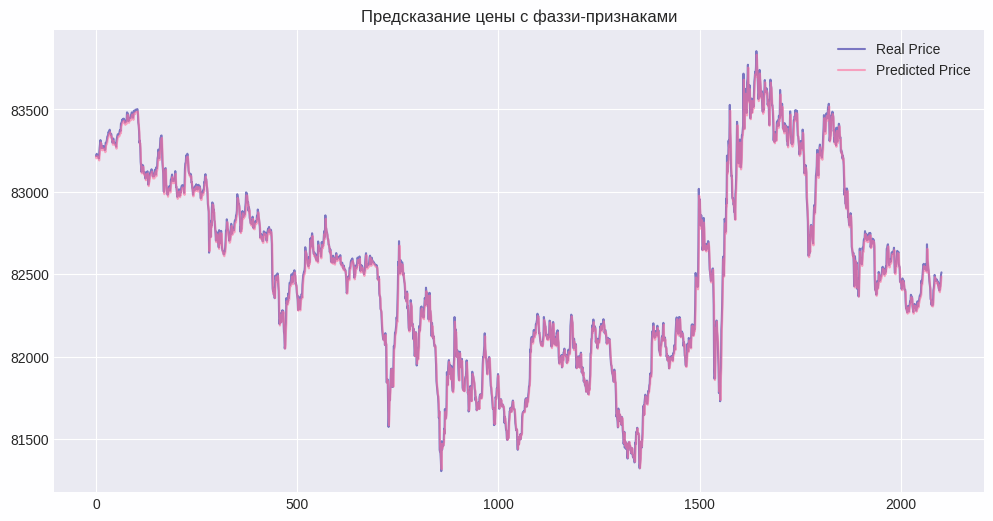

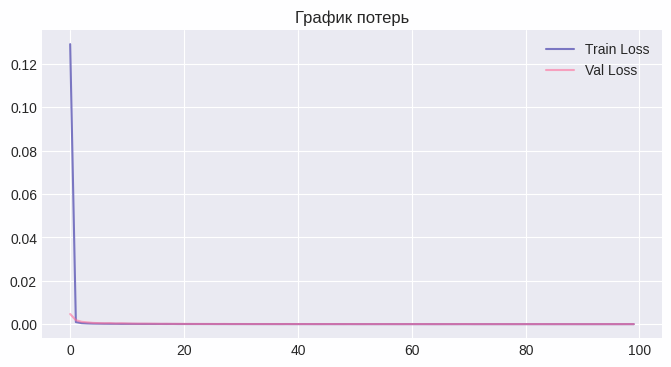

In [ ]:
# === –î–µ-–Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è —Ç–æ–ª—å–∫–æ –¥–ª—è –ø–µ—Ä–≤–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è (—Ü–µ–Ω—ã) ===
train_price = scaler.inverse_transform(train_y[:, 0].reshape(-1, 1))
test_price = scaler.inverse_transform(test_y[:, 0].reshape(-1, 1))
train_pred_price = scaler.inverse_transform(train_predict[:, 0].reshape(-1, 1))
test_pred_price = scaler.inverse_transform(test_predict[:, 0].reshape(-1, 1))

# === –ú–µ—Ç—Ä–∏–∫–∏ ===
rmse_train= math.sqrt(mean_squared_error(train_price,train_pred_price))
mae_train=mean_absolute_error(train_price,train_pred_price)
mape_train=mean_absolute_percentage_error(train_price,train_pred_price)
rmse_test=math.sqrt(mean_squared_error(test_price, test_pred_price))
mae_test=mean_absolute_error(test_price, test_pred_price)
mape_test=mean_absolute_percentage_error(test_price, test_pred_price)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ===
plt.figure(figsize=(12, 6))
plt.plot(test_price, label='Real Price')
plt.plot(test_pred_price, label='Predicted Price')
plt.title("–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —Ü–µ–Ω—ã —Å —Ñ–∞–∑–∑–∏-–ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("–ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å")
plt.legend()
plt.show()


–î—Ä—É–≥–æ–π –ø–æ–¥—Ö–æ–¥ (–°–∞–º—ã–π –ø—Ä–∞–≤–∏–ª—å–Ω—ã–π):

+---------+-----------------------+-----------------------+
| RESULTS |         TRAIN         |          TEST         |
+---------+-----------------------+-----------------------+
|   rmse  |   31.647587348979812  |   38.148558070631495  |
|   mae   |   22.00328721336579   |   23.642940503092294  |
|   mape  | 0.0002541423875825095 | 0.0002816501518910723 |
+---------+-----------------------+-----------------------+


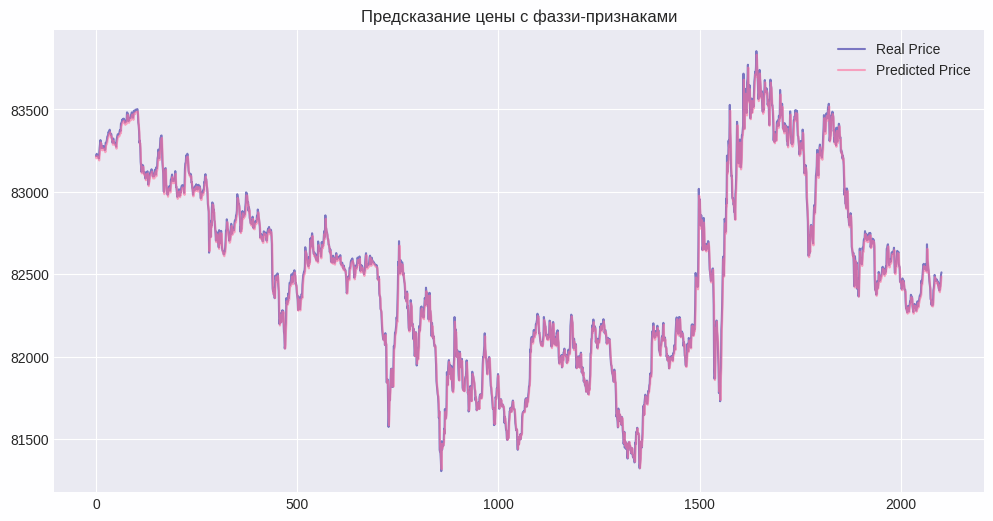

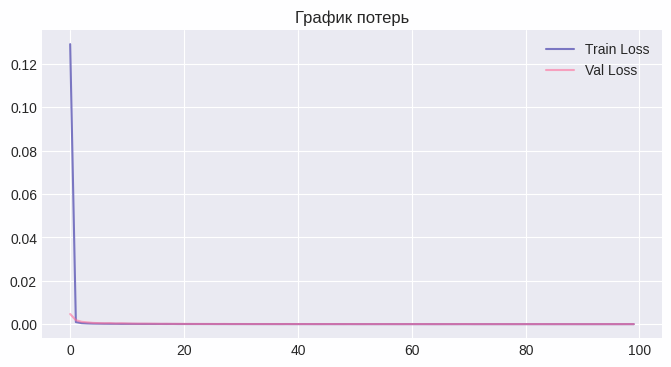

In [ ]:
#–î–µ-–Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –∏ —Ä–µ–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
train_pred_denorm = scaler.inverse_transform(train_predict.T.reshape(-1, 1))
test_pred_denorm = scaler.inverse_transform(test_predict.T.reshape(-1, 1))
y_train_denorm = scaler.inverse_transform(train_y.T.reshape(-1, 1))
y_test_denorm = scaler.inverse_transform(test_y.T.reshape(-1, 1))


# === –ú–µ—Ç—Ä–∏–∫–∏ ===
rmse_train= math.sqrt(mean_squared_error(y_train_denorm, train_pred_denorm))
mae_train=mean_absolute_error(y_train_denorm, train_pred_denorm)
mape_train=mean_absolute_percentage_error(y_train_denorm, train_pred_denorm)
rmse_test=math.sqrt(mean_squared_error(y_test_denorm, test_pred_denorm))
mae_test=mean_absolute_error(y_test_denorm, test_pred_denorm)
mape_test=mean_absolute_percentage_error(y_test_denorm, test_pred_denorm)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ===
l = np.shape(y_test_denorm)[0]
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm[:int(l/2),0], label='Real Price')
plt.plot(test_pred_denorm[:int(l/2),0], label='Predicted Price')
plt.title("–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —Ü–µ–Ω—ã —Å —Ñ–∞–∑–∑–∏-–ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("–ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å")
plt.legend()
plt.show()




-------


----

**Probabilistic Fuzzy Sets**
- –æ–ø—Ä–µ–¥–µ–ª–∏–º –æ–±–ª–∞—Å—Ç—å —Ä–∞—Å—Å—É–∂–¥–µ–Ω–∏–π $U = [X_{min} - \sigma, X_{max} + \sigma], X_{min}$ –∏ $X_{max}$ -- –º–∏–Ω–∏–º–∞–ª—å–Ω—ã–µ –∏ –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è —Ä—è–¥–∞ –∑–∞ –æ–±–æ–∑—Ä–µ–≤–∞–µ–º—ã–π –ø–µ—Ä–∏–æ–¥, $\sigma$ -- –¥–∏—Å–ø–µ—Ä—Å–∏—è.
- –†–∞–∑–æ–±—å–µ–º $U$ –Ω–∞ $m$ —Ä–∞–≤–Ω—ã—Ö –∏–Ω—Ç–µ—Ä–≤–∞–ª–æ–≤ $e_i$ –∏ –∑–∞–¥–∞–¥–∏–º –Ω–∞ –Ω–∏—Ö —Ç—Ä–µ—É–≥–æ–ª—å–Ω—ã–º–∏ —Ñ—É–Ω–∫—Ü–∏—è–º–∏ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏ –Ω–µ—á–µ—Ç–∫–∏–µ –º–Ω–æ–∂–µ—Å—Ç–≤–∞ $F_i$


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, time
from datetime import date, timedelta
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prettytable import PrettyTable

In [ ]:

# === 1Ô∏è‚É£ –ü–∞—Ä–∞–º–µ—Ç—Ä—ã
step = '1m'
companies = 'BTC-USD'
lookback = 30
unit = 16
m_fuzzy = 14  # –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ—á–µ—Ç–∫–∏—Ö –º–Ω–æ–∂–µ—Å—Ç–≤

In [ ]:
# === 2Ô∏è‚É£ –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö
def get_historical_close_data(name, step):
    if step == '1d':
        start, end, interval = '2018-01-01', '2024-02-15', '1d'
    elif step == '1h':
        start, end, interval = '2023-01-01', '2024-02-15', '1h'
    else:
        start, end, interval = date.today() - timedelta(days=7), date.today(), '1m'
    data = yf.Ticker(name).history(start=start, end=end, interval=interval)
    data.reset_index(inplace=True)
    return data[['Close']]

In [ ]:
# === 3Ô∏è‚É£ –§–∞–∑–∑–∏—Ñ–∏–∫–∞—Ü–∏—è
def probabilistic_fuzzy_transform(data, m):
    X_min, X_max = np.min(data), np.max(data)
    sigma = np.std(data)
    U_min, U_max = X_min - sigma, X_max + sigma
    centers = np.linspace(U_min, U_max, m)

    def triangle_membership(x):
        membership = np.zeros(m)
        for i, c in enumerate(centers):
            if i == 0:
                left, right = centers[i], centers[i+1]
            elif i == m-1:
                left, right = centers[i-1], centers[i]
            else:
                left, right = centers[i-1], centers[i+1]
            if left < x < c:
                membership[i] = (x - left) / (c - left)
            elif c < x < right:
                membership[i] = (right - x) / (right - c)
            elif x == c:
                membership[i] = 1
            else:
                membership[i] = 0
        return membership

    fuzzy_data = np.array([triangle_membership(x[0]) for x in data])
    return fuzzy_data, centers

In [ ]:
# === 4Ô∏è‚É£ –î–µ—Ñ–∞–∑–∑–∏—Ñ–∏–∫–∞—Ü–∏—è
def defuzzify(output_fuzzy, centers):
    return np.dot(output_fuzzy, centers) / np.sum(output_fuzzy, axis=1)

In [ ]:
def create_dataset_multifeature(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i:(i + lookback), :]
        dataX.append(a)
        dataY.append(dataset[i + lookback, :])
    return np.array(dataX), np.array(dataY)

In [ ]:
# === 5Ô∏è‚É£ –°–æ–∑–¥–∞–Ω–∏–µ –¥–∞—Ç–∞—Å–µ—Ç–∞
def create_dataset(X, y, lookback):
    dataX, dataY = [], []
    for i in range(len(X) - lookback - 1):
        dataX.append(X[i:i+lookback])
        dataY.append(y[i + lookback,:])
    return np.array(dataX), np.array(dataY)

In [ ]:
# === üîÅ –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ
raw_data = get_historical_close_data(companies, step)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(raw_data.values)
fuzzy_data, centers = probabilistic_fuzzy_transform(scaled_close, m_fuzzy)

#X, y = create_dataset(fuzzy_data, scaled_close, lookback)

X, y = create_dataset(fuzzy_data, fuzzy_data, lookback)
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# === 6Ô∏è‚É£ –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = Sequential()
model.add(Input(shape=(lookback, m_fuzzy)))  # –í–æ—Ç —Ç–∞–∫ –ø—Ä–∞–≤–∏–ª—å–Ω–æ
model.add(LSTM(unit))
model.add(Dense(m_fuzzy))  # –í—ã—Ö–æ–¥ ‚Äî –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
start_time = time.time()
result = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0)
train_time = time.time() - start_time

In [ ]:
# === 7Ô∏è‚É£ –ü—Ä–æ–≥–Ω–æ–∑
train_pred_fuzzy = model.predict(X_train)
test_pred_fuzzy = model.predict(X_test)

train_pred = defuzzify(train_pred_fuzzy, centers)
test_pred = defuzzify(test_pred_fuzzy, centers)
y_train_defuzzy = defuzzify(y_train, centers)
y_test_defuzzy = defuzzify(y_test, centers)

200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step
67/67 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step


In [ ]:
# === 8Ô∏è‚É£ –î–µ-–Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
train_pred_denorm = scaler.inverse_transform(train_pred.reshape(-1,1))
test_pred_denorm = scaler.inverse_transform(test_pred.reshape(-1,1))
y_train_denorm = scaler.inverse_transform(y_train_defuzzy.reshape(-1,1))
y_test_denorm = scaler.inverse_transform(y_test_defuzzy.reshape(-1,1))

+--------+------------------------+-----------------------+
| METRIC |         TRAIN          |          TEST         |
+--------+------------------------+-----------------------+
|  RMSE  |   47.97719195859565    |   57.64621501887154   |
|  MAE   |   35.276680300800905   |   41.010659762795214  |
|  MAPE  | 0.00041166642357427476 | 0.0004970602465432128 |
+--------+------------------------+-----------------------+


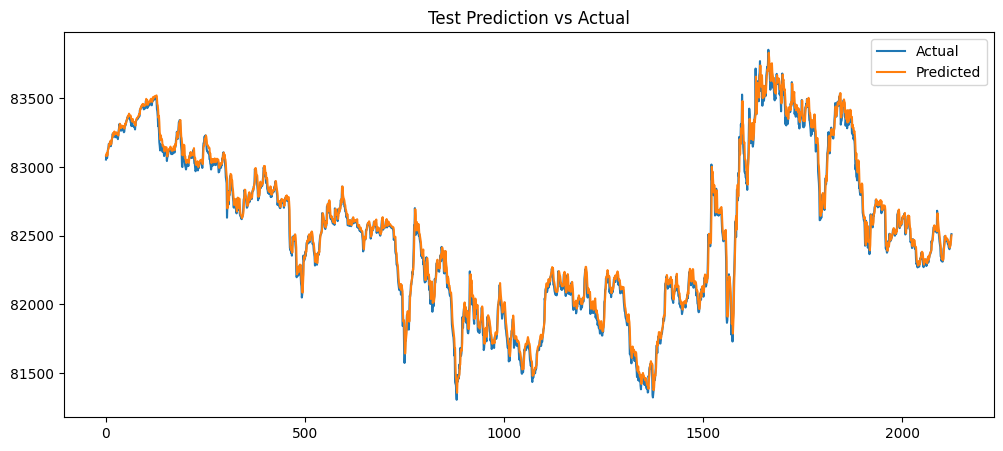

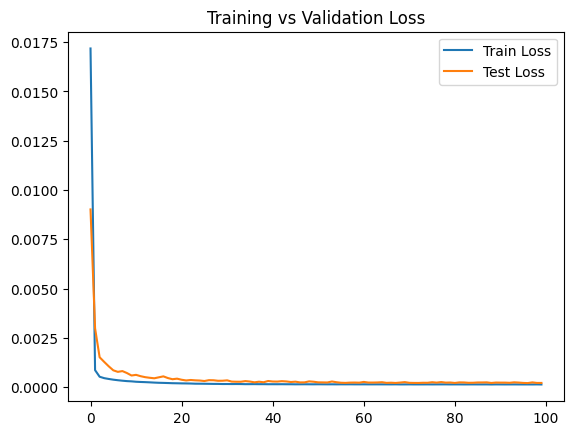

In [ ]:
# === 9Ô∏è‚É£ –ú–µ—Ç—Ä–∏–∫–∏
def calc_metrics(y_true, y_pred):
    return (
        math.sqrt(mean_squared_error(y_true, y_pred)),
        mean_absolute_error(y_true, y_pred),
        mean_absolute_percentage_error(y_true, y_pred)
    )

rmse_train, mae_train, mape_train = calc_metrics(y_train_denorm, train_pred_denorm)
rmse_test, mae_test, mape_test = calc_metrics(y_test_denorm, test_pred_denorm)

table = PrettyTable()
table.field_names = ["METRIC", "TRAIN", "TEST"]
table.add_row(["RMSE", f"{rmse_train:}", f"{rmse_test:}"])
table.add_row(["MAE", f"{mae_train:}", f"{mae_test:}"])
table.add_row(["MAPE", f"{mape_train:}", f"{mape_test:}"])
print(table)

# === üîü –ì—Ä–∞—Ñ–∏–∫ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
plt.figure(figsize=(12,5))
plt.plot(y_test_denorm, label="Actual")
plt.plot(test_pred_denorm, label="Predicted")
plt.title("Test Prediction vs Actual")
plt.legend()
plt.show()

# === üìâ –ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å
plt.plot(result.history['loss'], label='Train Loss')
plt.plot(result.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


---------
----------